<a href="https://colab.research.google.com/github/surekha2907/Leave-Management/blob/main/Project02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# Create Kaggle folder
os.makedirs('/root/.kaggle', exist_ok=True)

# Move kaggle.json to the Kaggle folder
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


In [2]:
# Download the dataset
!kaggle competitions download -c histopathologic-cancer-detection

# Unzip the downloaded file
!unzip histopathologic-cancer-detection.zip -d cancer_detection


Streaming output truncated to the last 5000 lines.
  inflating: cancer_detection/train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: cancer_detection/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: cancer_detection/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: cancer_detection/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: cancer_detection/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: cancer_detection/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: cancer_detection/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: cancer_detection/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: cancer_detection/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: cancer_detection/train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: cancer_detection/train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: cancer_detection/train/

In [5]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths (update to your dataset paths)
train_dir = "/content/cancer_detection/train"  # Directory containing train images
labels_file = "/content/cancer_detection/train_labels.csv"  # CSV file with labels

# Load dataset
data = pd.read_csv(labels_file)
data['file_path'] = data['id'].apply(lambda x: os.path.join(train_dir, f"{x}.tif"))

# Filter valid file paths
data = data[data['file_path'].apply(os.path.exists)].reset_index(drop=True)
print(f"Dataset size after filtering: {len(data)}")

# Subset the data (5000 images)
subset_size = min(5000, len(data))
data_subset = data.sample(n=subset_size, random_state=42).reset_index(drop=True)
print(f"Subset size: {len(data_subset)}")

# Train/Validation split
train_df, val_df = train_test_split(data_subset, test_size=0.2, stratify=data_subset['label'], random_state=42)
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Dataset class
class CancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = cv2.imread(row['file_path'])
        if image is None:
            raise FileNotFoundError(f"Image not found: {row['file_path']}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = row['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Data augmentations
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transforms_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# DataLoaders
batch_size = 32
train_dataset = CancerDataset(train_df, transform=transforms_train)
val_dataset = CancerDataset(val_df, transform=transforms_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Custom CNN model
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 24 * 24)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Pretrained ResNet model
def get_pretrained_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 1),
        nn.Sigmoid()  # Add sigmoid activation to the final layer
    )
    return model

# Training function
def train_model(model, train_loader, val_loader, optimizer, scheduler, n_epochs=10):
    model.to(device)
    criterion = nn.BCELoss()

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_targets = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_preds.extend(outputs.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        auc = roc_auc_score(val_targets, val_preds)
        print(f"Epoch {epoch + 1}/{n_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - AUC: {auc:.4f}")
        if scheduler:
            scheduler.step()

# Train Custom Model
custom_model = CustomModel()
optimizer_custom = optim.Adam(custom_model.parameters(), lr=0.001)
scheduler_custom = StepLR(optimizer_custom, step_size=5, gamma=0.1)
train_model(custom_model, train_loader, val_loader, optimizer_custom, scheduler_custom, n_epochs=10)

# Train Pretrained ResNet Model
pretrained_model = get_pretrained_model()
optimizer_pretrained = optim.SGD(pretrained_model.parameters(), lr=0.01, momentum=0.9)
scheduler_pretrained = CosineAnnealingLR(optimizer_pretrained, T_max=10)
train_model(pretrained_model, train_loader, val_loader, optimizer_pretrained, scheduler_pretrained, n_epochs=10)

# Plot ROC Curve
def plot_roc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, label=f"AUC: {roc_auc_score(y_true, y_pred):.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


Using device: cpu
Dataset size after filtering: 220025
Subset size: 5000
Training set size: 4000
Validation set size: 1000
Epoch 1/10 - Train Loss: 76.1188 - Val Loss: 15.0893 - AUC: 0.8508
Epoch 2/10 - Train Loss: 58.3418 - Val Loss: 14.5599 - AUC: 0.8632
Epoch 3/10 - Train Loss: 56.7789 - Val Loss: 15.0646 - AUC: 0.8634
Epoch 4/10 - Train Loss: 53.6706 - Val Loss: 13.5630 - AUC: 0.8826
Epoch 5/10 - Train Loss: 51.9500 - Val Loss: 13.5357 - AUC: 0.8891
Epoch 6/10 - Train Loss: 47.6332 - Val Loss: 12.8007 - AUC: 0.8921
Epoch 7/10 - Train Loss: 46.9531 - Val Loss: 12.7962 - AUC: 0.8918
Epoch 8/10 - Train Loss: 46.3415 - Val Loss: 12.6586 - AUC: 0.8930
Epoch 9/10 - Train Loss: 45.9186 - Val Loss: 12.7870 - AUC: 0.8927
Epoch 10/10 - Train Loss: 45.6723 - Val Loss: 12.6582 - AUC: 0.8948


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Train Loss: 64.6461 - Val Loss: 12.0237 - AUC: 0.9209
Epoch 2/10 - Train Loss: 44.5725 - Val Loss: 10.9494 - AUC: 0.9265
Epoch 3/10 - Train Loss: 38.0029 - Val Loss: 9.6097 - AUC: 0.9568
Epoch 4/10 - Train Loss: 33.6680 - Val Loss: 8.1892 - AUC: 0.9604
Epoch 5/10 - Train Loss: 31.6945 - Val Loss: 7.4029 - AUC: 0.9639
Epoch 6/10 - Train Loss: 26.9932 - Val Loss: 8.5773 - AUC: 0.9614
Epoch 7/10 - Train Loss: 25.9967 - Val Loss: 7.2329 - AUC: 0.9696
Epoch 8/10 - Train Loss: 24.5171 - Val Loss: 7.0186 - AUC: 0.9696
Epoch 9/10 - Train Loss: 21.6276 - Val Loss: 6.6603 - AUC: 0.9725
Epoch 10/10 - Train Loss: 21.1542 - Val Loss: 6.5534 - AUC: 0.9733


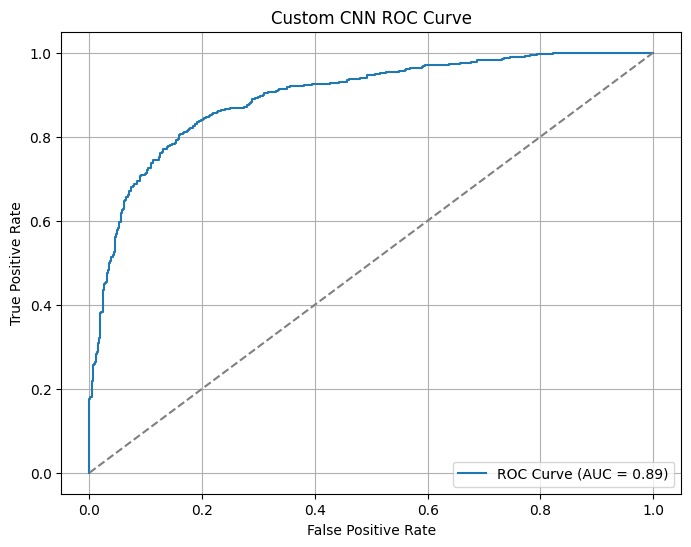

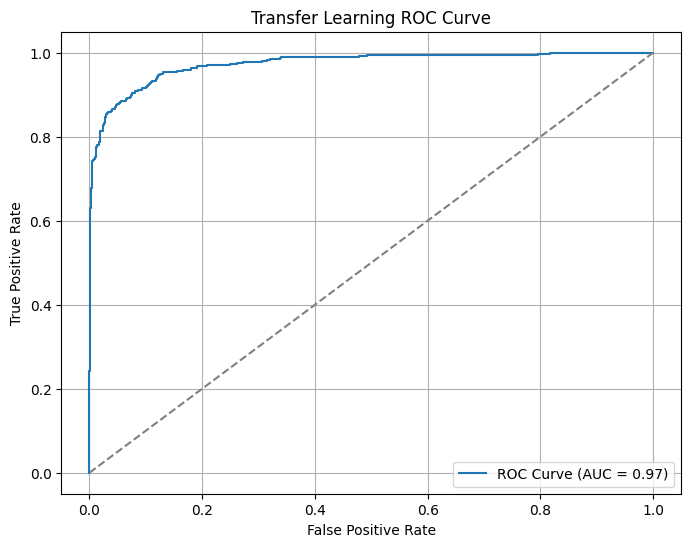

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import torch

def plot_roc_curve(model, val_loader, title):
    """
    Plot the ROC curve for a given model and validation DataLoader.

    Args:
    - model: PyTorch model.
    - val_loader: PyTorch DataLoader for validation data.
    - title: Title of the plot.
    """
    model.eval()  # Set the model to evaluation mode
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images).squeeze()  # Get model predictions
            val_preds.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    # Ensure predictions are probabilities
    val_preds = torch.sigmoid(torch.tensor(val_preds)).numpy()

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(val_targets, val_preds)
    auc = roc_auc_score(val_targets, val_preds)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Plot ROC curve for the Custom CNN model
plot_roc_curve(custom_model, val_loader, "Custom CNN ROC Curve")

# Plot ROC curve for the Transfer Learning model
plot_roc_curve(pretrained_model, val_loader, "Transfer Learning ROC Curve")
